In [200]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib import font_manager
import numpy as np
from scipy.optimize import curve_fit
import os
from datetime import datetime

#%% FORMATO GRAFICAS
def formato_grafico(ax=None, decimalx=None, decimaly=None, legend_loc='upper right'):
    if ax is None:
        ax = plt.gca()

    fuente = 'sans'
    ax.title.set_size(14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.title.set_family(fuente)
    ax.yaxis.label.set_family(fuente)
    ax.xaxis.label.set_family(fuente)
    ax.tick_params(axis='both', labelsize=14)

    plt.rcParams['mathtext.fontset'] = 'cm'  
    plt.rcParams['mathtext.rm'] = 'sans'  
    plt.rcParams['mathtext.default'] = 'rm'

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, top=True)
    ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)

    # Configurar la notación científica
    if decimalx is not None:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimalx}f}' if x != 0 else '0'))

    if decimaly is not None:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimaly}f}' if x != 0 else '0'))

    if ax.get_legend() is not None:
        ax.legend(fontsize=16)

    font = font_manager.FontProperties(family='sans', style='normal', size=16)

    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        ax.legend(loc=legend_loc, handles=handles, labels=labels, edgecolor='1', framealpha=0.5, prop=font)
#%% FUNCIONES LORENTZIANA Y AJUSTES

def lorentz(x, A, B, C, x0, gamma):
    """Función Lorentziana con una recta de base."""
    return A + B * (x - x0) + (C / (1 + ((x - x0) / gamma) ** 2))

def lorentz_ajuste(x, y):
    """Ajuste de la curva Lorentziana."""
    x0 = sum(x * y) / sum(y)  # Media ponderada como estimación inicial
    gamma = np.sqrt(sum(y * (x - x0) ** 2) / sum(y))  # Ancho inicial estimado
    popt, pcov = curve_fit(lorentz, x, y, p0=[1, 1, max(y), x0, gamma])
    return popt, pcov

def Ajuste_lorentziano(canal, cuentas, extremo_inferior, extremo_superior,
                        a_0=0, a_1=1, unidades='keV', titulo='Ajuste Lorentziano', ylim=None):
    """Realiza el ajuste de una función Lorentziana a los datos proporcionados."""
    
    x = canal[extremo_inferior:extremo_superior]
    y = cuentas[extremo_inferior:extremo_superior]
    x = x * a_1 + a_0  # Transformación lineal del eje x

    # Ajuste de la Lorentziana
    popt, pcov = lorentz_ajuste(x, y)
    A, B, C, x0, gamma = popt

    # Generación de la curva ajustada
    x_ajuste = np.linspace(extremo_inferior, extremo_superior, 100) * a_1 + a_0
    y_ajuste = lorentz(x_ajuste, A, B, C, x0, gamma)
    recta_ajuste = A + B * (x_ajuste - x0)

    # Full Width at Half Maximum (FWHM) para una Lorentziana
    FWHM = 2 * gamma  
    uncertainties = np.sqrt(np.diag(pcov))

    # Resultados del ajuste
    print("\nPico:     ", titulo)
    print("A:        {:.2f} ± {:.2f}".format(A, uncertainties[0]))
    print("B:        {:.3f} ± {:.3f}".format(B, uncertainties[1]))
    print("C:        {:.0f} ± {:.0f}".format(C, uncertainties[2]))
    print("x0:       {:.2f} ± {:.2f}".format(x0, uncertainties[3]))
    print("γ:        {:.2f} ± {:.2f}".format(abs(gamma), abs(uncertainties[4])))
    print("FWHM:     {:.2f} ± {:.2f}".format(abs(FWHM), abs(FWHM * (uncertainties[4] / gamma))))

    # Intensidad total (área bajo la Lorentziana)
    I = np.pi * C * gamma
    dI = I * np.sqrt((uncertainties[2] / C) ** 2 + (uncertainties[4] / gamma) ** 2)
    print("Intensidad: {:.0f} ± {:.0f}".format(abs(I), abs(dI)))

    # Gráfica del ajuste
    plt.figure(figsize=(10, 5))
    plt.step(x, y, 'k', label=f'{titulo}', where='mid')
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2,
             label=r'$A + B (x - x_0) + \frac{C}{1 + ((x - x_0)/\gamma)^2}$')
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2, label=r'$A + B (x - x_0) $')
    
    plt.grid()
    plt.ylabel(r'$\sigma(E)$' + ' [barn]')
    plt.xlabel(r'Energía (keV)')
    if ylim:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()

<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_4240/753801064.py:42: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Sección eficaz $\sigma(E)$")


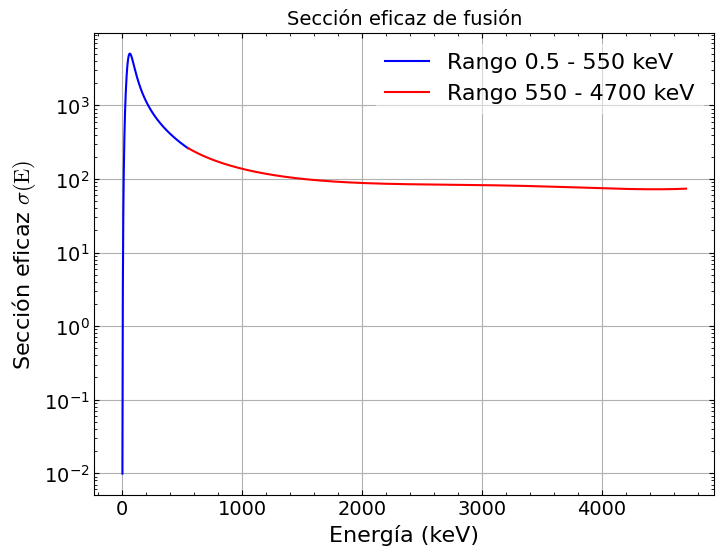

In [201]:

# Definición de los coeficientes para los dos rangos de energía

# Rango 1: 0.5 - 550 keV
A1_1, A2_1, A3_1, A4_1, A5_1 = 6.927e4, 7.454e8, 2.050e6, 5.2002e4, 0.0
B1_1, B2_1, B3_1, B4_1 = 6.38e1, -9.95e-1, 6.981e-5, 1.728e-4

# Rango 2: 550 - 4700 keV (de la imagen que enviaste)
A1_2, B1_2, B2_2, B3_2, B4_2 = -1.4714e6, -8.4127e-3, 4.7983e-6, -1.0748e-9, 8.5184e-14

# Energía de Gamow (ajustar según la situación específica)
m_r = 1124000  # [Kev]]Masa reducida (sistema deuterio-tritio)
c = 1 # Velocidad de la luz
alpha = 1/137.036  # Constante de estructura fina
Za, Zb = 1, 1  # Cargas de los núcleos en unidades de e

E_G = 2 * m_r * c**2 * (np.pi * alpha * Za * Zb)**2  # Energía de Gamow
B_g = np.sqrt(E_G)  # Se asume que B_g = E_G

# Función S(E)
def S_E(E, A1, A2, A3, A4, A5, B1, B2, B3, B4):
    num = A1 + E * (A2 + E * (A3 + E * (A4 + E * A5)))
    den = 1 + E * (B1 + E * (B2 + E * (B3 + E * B4)))
    return num / den

# Función sigma(E)
def sigma(E, A1, A2, A3, A4, A5, B1, B2, B3, B4):
    return S_E(E, A1, A2, A3, A4, A5, B1, B2, B3, B4) / (E * np.exp(B_g / np.sqrt(E)))

# Crear el rango de energía
E1 = np.linspace(3, 550, 300)
E2 = np.linspace(550, 4700, 300)

# Calcular sigma para cada rango
sigma_1 = sigma(E1, A1_1, A2_1, A3_1, A4_1, A5_1, B1_1, B2_1, B3_1, B4_1)
sigma_2 = sigma(E2, A1_2, 0, 0, 0, 0, B1_2, B2_2, B3_2, B4_2)  # A2-A5 no están en la imagen

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(E1, sigma_1, label="Rango 0.5 - 550 keV", color="b")
plt.plot(E2, sigma_2, label="Rango 550 - 4700 keV", color="r")
plt.xlabel("Energía (keV)")
plt.ylabel("Sección eficaz $\sigma(E)$")
plt.title("Sección eficaz de fusión")
plt.legend()
formato_grafico()
plt.yscale("log")  # Para ver mejor las diferencias
plt.grid()
plt.show()



Pico:      Ajuste Lorentziano al Pico de Resonancia
A:        894.74 ± 69.57
B:        -1.443 ± 0.208
C:        4102 ± 89
x0:       74.59 ± 0.63
γ:        34.59 ± 1.45
FWHM:     69.17 ± 2.89
Intensidad: 445748 ± 21001


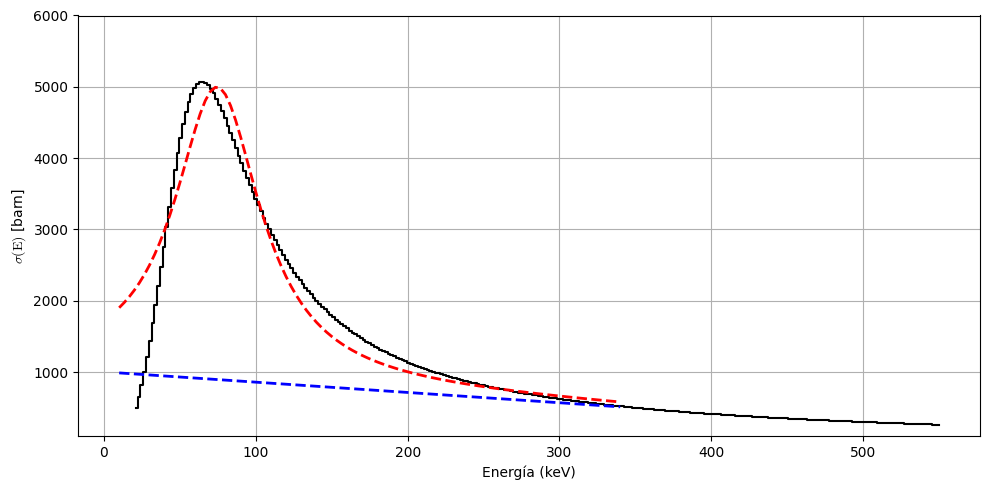

In [202]:
# Aplicar el ajuste en un rango de interés (seleccionando un pico)
Ajuste_lorentziano(E1, sigma_1, extremo_inferior=10, extremo_superior=340, 
                   titulo='Ajuste Lorentziano al Pico de Resonancia', ylim=[100, 6000])

In [219]:
#calculo de gamma observacional 
Gamma=69.17
Er=74.59
gammaob=np.sqrt(Gamma/(2*np.exp(-B_g / np.sqrt(Er))))
print(gammaob)
Gamma_12 = (Gamma**2)*sigma(Er, A1_1, A2_1, A3_1, A4_1, A5_1, B1_1, B2_1, B3_1, B4_1)*1.973e-11/(np.pi /( 2 * mu *Er))
print(Gamma_12)

43.01995618726984
24298.747338678833


<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_4240/2298470053.py:34: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Sección eficaz $\sigma(E)$")


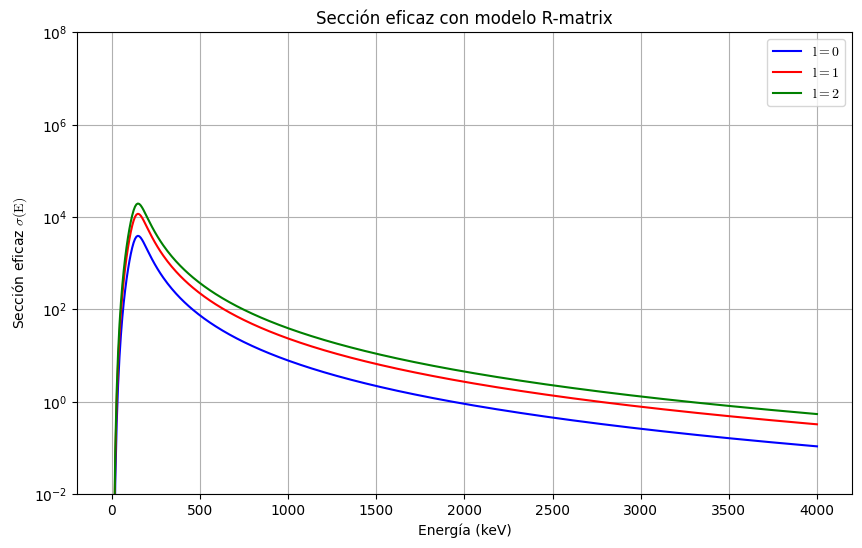

In [224]:
# Definición de la función R-matrix para la sección eficaz
def Rmatrixsigma(l, Gamma, E, Er, mu, B_g):
    """Cálculo de la sección eficaz usando el modelo R-matrix."""
    a=0.0003
    Gamma = 2 * Gamma * np.exp(B_g / np.sqrt(E))  # Ancho de la resonancia
    Gamma2 = 2 * 0.8**2 * np.exp(-B_g / np.sqrt(E))
    k = np.sqrt(2 * mu * E / np.pi)  # Número de onda
    Gamma = 2 * Gamma * (k*a+ (((a*k)**3)/1+(a*k)**2))**-1 # Ancho de la resonancia
    Sigma = (1 /k**2)*(2 * l + 1) * ((24298.747338678833) / ((E - Er)**2 + ((Gamma))**2 / 2))*1.973e11
    return Sigma

# Definir el rango de energía entre 0 y 4000 keV
E_range = np.linspace(3, 4000, 500)  # Evitar E=0 para evitar divisiones por cero

# Valores dados
Er = 74.59  # Energía de resonancia en keV
gammaob = 43  # Factor de ensanchamiento observado
mu = m_r  # Masa reducida del sistema deuterio-tritio

# Calcular sigma para l = 0, 1, 2
sigma_l0 = Rmatrixsigma(0, Gamma, E_range, Er, mu, B_g)
sigma_l1 = Rmatrixsigma(1, Gamma, E_range, Er, mu, B_g)
sigma_l2 = Rmatrixsigma(2, Gamma, E_range, Er, mu, B_g)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(E_range, sigma_l0, label=r'$l=0$', color='b')
plt.plot(E_range, sigma_l1, label=r'$l=1$', color='r')
plt.plot(E_range, sigma_l2, label=r'$l=2$', color='g')

# Configuración del gráfico
plt.ylim([0.01, 100000000])
plt.xlabel("Energía (keV)")
plt.ylabel("Sección eficaz $\sigma(E)$")
plt.title("Sección eficaz con modelo R-matrix")
plt.legend()
plt.yscale("log")
plt.grid()
plt.show()


<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_4240/1716259430.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Sección eficaz $\sigma(E)$")


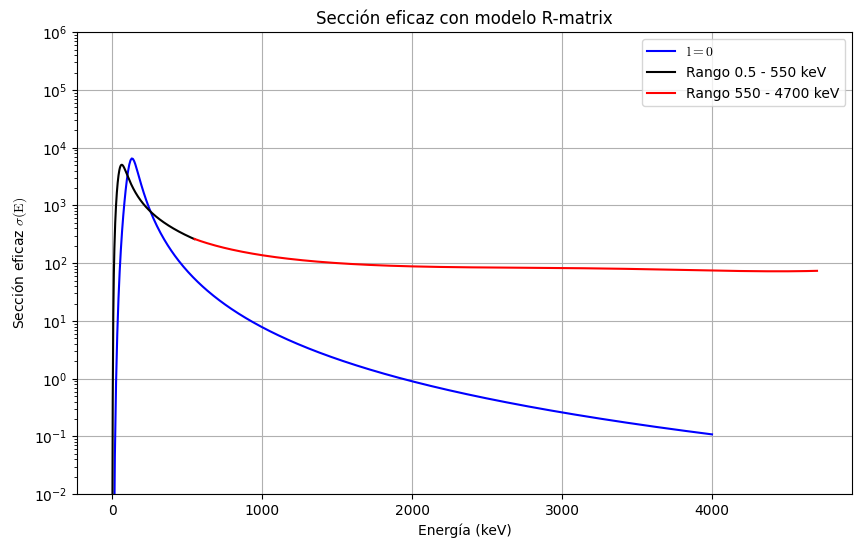

In [225]:
# Calcular sigma para l = 0, 1, 2
sigma_l0 = Rmatrixsigma(0, gammaob, E_range, Er, mu, B_g)#/35543.49997171258
sigma_1 = sigma(E1, A1_1, A2_1, A3_1, A4_1, A5_1, B1_1, B2_1, B3_1, B4_1)
sigma_2 = sigma(E2, A1_2, 0, 0, 0, 0, B1_2, B2_2, B3_2, B4_2)  # A2-A5 no están en la imagen


# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(E_range, sigma_l0, label=r'$l=0$', color='b')
plt.plot(E1, sigma_1, label="Rango 0.5 - 550 keV", color="k")
plt.plot(E2, sigma_2, label="Rango 550 - 4700 keV", color="r")


# Configuración del gráfico
plt.ylim([0.01, 1000000])
plt.xlabel("Energía (keV)")
plt.ylabel("Sección eficaz $\sigma(E)$")
plt.title("Sección eficaz con modelo R-matrix")
plt.legend()
plt.yscale("log")
plt.grid()
plt.show()


In [68]:
1e-12 * 1.973e32 * 1e-28

1.973e-08

/tmp/ipykernel_4240/3722823588.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  popt1, _ = curve_fit(lambda E, a, c: sigma(E, A1_1, A2_1, A3_1, A4_1, A5_1, B1_1, B2_1, B3_1, B4_1, a, c), E1, sigma_vals1, p0=[0.0009, 1])
/tmp/ipykernel_4240/3722823588.py:47: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, _ = curve_fit(lambda E, a, c: sigma(E, A1_2, 0, 0, 0, 0, B1_2, B2_2, B3_2, B4_2, a, c), E2, sigma_vals2, p0=[0.0009, 1])


Parámetros óptimos para el rango 1: a = 0.0009, c = 1.0
Parámetros óptimos para el rango 2: a = 0.0009, c = 1.0


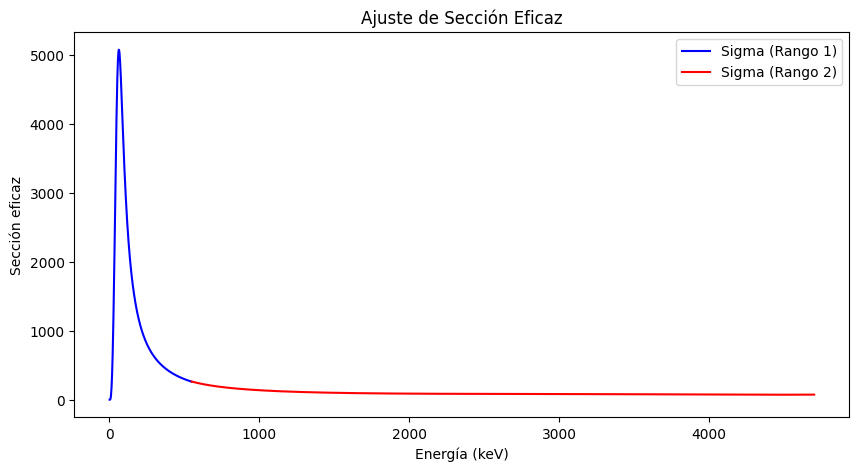

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def Rmatrixsigma(l, Gamma, E, Er, mu, B_g, a, c):
    """Cálculo de la sección eficaz usando el modelo R-matrix."""
    Gamma = 2 * Gamma * np.exp(B_g / np.sqrt(E))  # Ancho de la resonancia
    Gamma2 = 2 * 0.8**2 * np.exp(-B_g / np.sqrt(E))
    k = np.sqrt(2 * mu * E / np.pi)  # Número de onda
    Gamma = 2 * Gamma * (k*a + (((a*k)**3) / (1 + (a*k)**2)))**-1 # Ancho de la resonancia
    Sigma = (1 / k**2) * (2 * l + 1) * (c / ((E - Er)**2 + (Gamma**2 / 2))) * 1.973e11
    return Sigma

# Definición de la función S(E)
def S_E(E, A1, A2, A3, A4, A5, B1, B2, B3, B4):
    num = A1 + E * (A2 + E * (A3 + E * (A4 + E * A5)))
    den = 1 + E * (B1 + E * (B2 + E * (B3 + E * B4)))
    return num / den

# Definición de la función sigma(E)
def sigma(E, A1, A2, A3, A4, A5, B1, B2, B3, B4, a, c):
    return S_E(E, A1, A2, A3, A4, A5, B1, B2, B3, B4) / (E * np.exp(B_g / np.sqrt(E)))

# Parámetros dados
m_r = 1124000  # [keV] Masa reducida (sistema deuterio-tritio)
alpha = 1 / 137.036  # Constante de estructura fina
Za, Zb = 1, 1  # Cargas de los núcleos en unidades de e
E_G = 2 * m_r * (np.pi * alpha * Za * Zb)**2  # Energía de Gamow
B_g = np.sqrt(E_G)  # Se asume que B_g = E_G

# Parámetros de ajuste
A1_1, A2_1, A3_1, A4_1, A5_1 = 6.927e4, 7.454e8, 2.050e6, 5.2002e4, 0.0
B1_1, B2_1, B3_1, B4_1 = 6.38e1, -9.95e-1, 6.981e-5, 1.728e-4

A1_2, B1_2, B2_2, B3_2, B4_2 = -1.4714e6, -8.4127e-3, 4.7983e-6, -1.0748e-9, 8.5184e-14

# Crear el rango de energía
E1 = np.linspace(3, 550, 300)
E2 = np.linspace(550, 4700, 300)

# Generar datos sintéticos basados en sigma(E)
sigma_vals1 = sigma(E1, A1_1, A2_1, A3_1, A4_1, A5_1, B1_1, B2_1, B3_1, B4_1, 0.0009, 1)
sigma_vals2 = sigma(E2, A1_2, 0, 0, 0, 0, B1_2, B2_2, B3_2, B4_2, 0.0009, 1)

# Ajuste de parámetros
popt1, _ = curve_fit(lambda E, a, c: sigma(E, A1_1, A2_1, A3_1, A4_1, A5_1, B1_1, B2_1, B3_1, B4_1, a, c), E1, sigma_vals1, p0=[0.0009, 1])
popt2, _ = curve_fit(lambda E, a, c: sigma(E, A1_2, 0, 0, 0, 0, B1_2, B2_2, B3_2, B4_2, a, c), E2, sigma_vals2, p0=[0.0009, 1])

# Mostrar resultados
a_opt1, c_opt1 = popt1
a_opt2, c_opt2 = popt2
print(f"Parámetros óptimos para el rango 1: a = {a_opt1}, c = {c_opt1}")
print(f"Parámetros óptimos para el rango 2: a = {a_opt2}, c = {c_opt2}")

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(E1, sigma_vals1, label='Sigma (Rango 1)', color='blue')
plt.plot(E2, sigma_vals2, label='Sigma (Rango 2)', color='red')
plt.xlabel('Energía (keV)')
plt.ylabel('Sección eficaz')
plt.legend()
plt.title('Ajuste de Sección Eficaz')
plt.show()
